## Load Library

In [81]:
!pip install yfinance 

In [82]:
import yfinance as yf
import os

In [84]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import set_option
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
import seaborn as sns

In [85]:
if os.path.exists("sp500.csv"):
    data = pd.read_csv("sp500.csv", index_col=0)
else:
    data = yf.Ticker("^GSPC")
    data = data.history(period="max")
    data.to_csv("sp500.csv")

In [86]:
data.index = pd.to_datetime(data.index)

In [87]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,0,0
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,0,0
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,0,0


Quan sát data, ta thấy có 4 features giá cổ phiếu:
- Open: Giá mở bán
- High: Giá cao nhất trong ngày
- Low: Giá thấp nhất trong ngày
- Close: Giá đóng cửa

<Axes: xlabel='Date'>

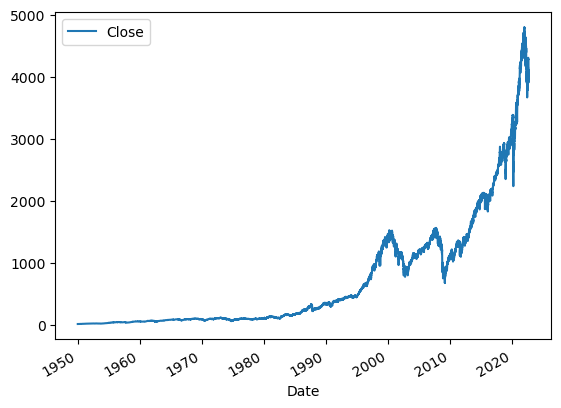

In [88]:
data.plot.line(y="Close", use_index=True)

Ta xóa đi hai feature không cần thiết là Dividents và Stock Splits

In [89]:
del data["Dividends"]
del data["Stock Splits"]

Thêm cột Tomorrow, giá kết thúc của ngày hôm sau. Dựa vào đây ta có thể xác định được mục tiêu là giá cổ phiếu sẽ có xu hướng tăng lên hay hạ xuống trong ngày tiếp theo.

In [90]:
data["Tomorrow"] = data["Close"].shift(-1)
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

In [91]:
data = data.loc["2003-01-01":].copy()

In [ ]:
Vì cổ phiếu là thị trường rất biến động, ta chỉ lấy data từ năm 2003 đến nay

In [92]:
data

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2003-01-02,879.820007,909.030029,879.820007,909.030029,1229200000,908.590027,0
2003-01-03,909.030029,911.250000,903.070007,908.590027,1130800000,929.010010,1
2003-01-06,908.590027,931.770020,908.590027,929.010010,1435900000,922.929993,0
2003-01-07,929.010010,930.809998,919.929993,922.929993,1545200000,909.929993,0
2003-01-08,922.929993,922.929993,908.320007,909.929993,1467600000,927.570007,1
...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,3979.870117,1
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,4006.179932,1
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,4067.360107,1


Xem phần trăm phân bổ của biến dữ liệu -> cân bằng

<Axes: title={'center': 'Target'}>

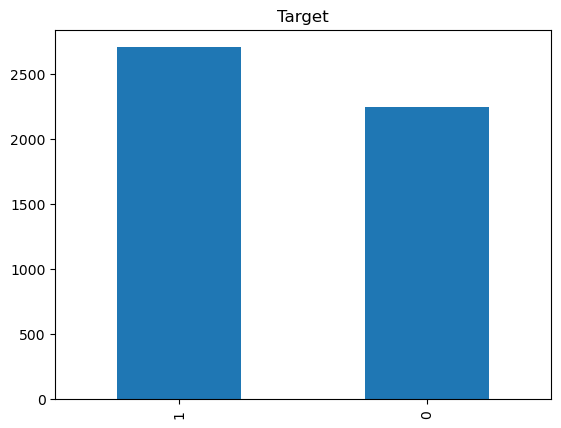

In [93]:
data['Target'].value_counts().plot(kind='bar', title = "Target")

In [95]:
del data["Tomorrow"]

## Train Model

In [96]:
x = data.drop('Target', axis=1)
y = data['Target']

In [97]:
print(x.shape, y.shape)

(4958, 5) (4958,)


In [99]:
validation_size = 0.20
seed = 7
X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=validation_size, random_state=seed)

In [100]:
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ",X_validation.shape, y_validation.shape)

Train:  (3966, 5) (3966,)
Validation:  (992, 5) (992,)


In [101]:
# Test options and evaluation metric
# X_train
num_folds = 10
scoring = 'accuracy'

In [102]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [103]:
results = []
names = []
for name, model in models:
  sfolder = StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=sfolder, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.547404 (0.000866)
LDA: 0.546646 (0.007969)
KNN: 0.516372 (0.026446)
CART: 0.516897 (0.030810)
NB: 0.545892 (0.003592)
SVM: 0.547404 (0.000866)


In [104]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
results = []
names = []
for name, model in pipelines:
  sfolder = StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=sfolder, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: 0.546899 (0.001372)
ScaledLDA: 0.546646 (0.007969)
ScaledKNN: 0.524207 (0.011977)
ScaledCART: 0.513358 (0.026693)
ScaledNB: 0.539085 (0.015540)
ScaledSVM: 0.544633 (0.006019)


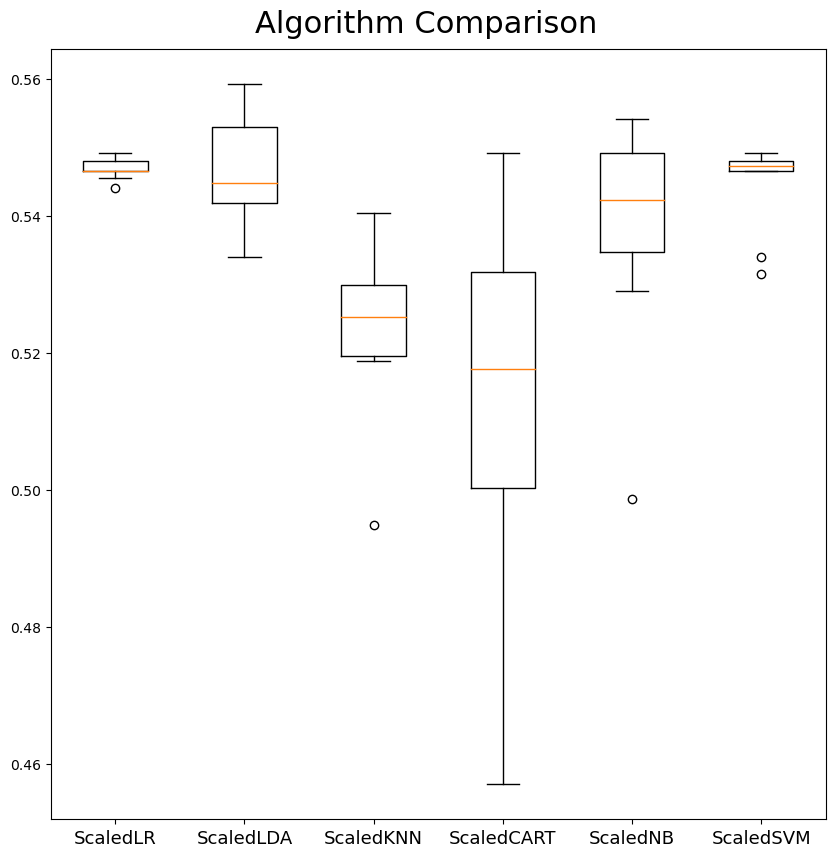

In [105]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison',fontsize=22, y=0.92)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,fontsize=13)
plt.show()

NB, LDA

In [106]:
# Linear Discriminant Analysis - Parameter Tuning
LDA = LinearDiscriminantAnalysis()

## Search grid for optimal parameters
lda_param_grid = {"solver" : ["svd"],
              "tol" : [0.0001,0.0002,0.0003]}
sfolder = StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)
gsLDA = GridSearchCV(LDA, param_grid = lda_param_grid, cv=sfolder,
                     scoring="accuracy", n_jobs= 4, verbose = 1)
gsLDA.fit(X_train,y_train)
LDA_best = gsLDA.best_estimator_

# Best score
print("Best: %f using %s" % (gsLDA.best_score_, gsLDA.best_params_))
print(gsLDA.best_estimator_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best: 0.546646 using {'solver': 'svd', 'tol': 0.0001}
LinearDiscriminantAnalysis()


In [107]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
  sfolder = StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=sfolder, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)


AB: 0.541094 (0.007933)
GBM: 0.551178 (0.014067)
RF: 0.518153 (0.023102)
ET: 0.513112 (0.021286)


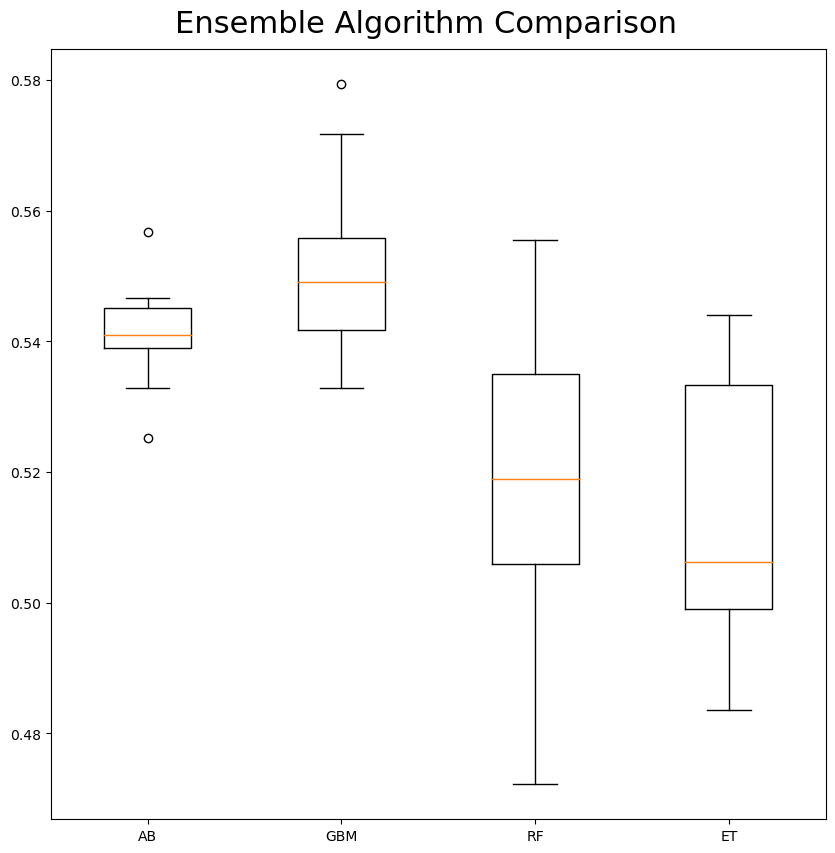

In [108]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Ensemble Algorithm Comparison',fontsize=22, y=0.92)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [113]:
modelLDA = LinearDiscriminantAnalysis(solver='svd',tol=0.0001)
modelLDA.fit(X_train, y_train)
pred=modelLDA.predict(X_validation)
print("Accuracy for LDA  on CV data: ",accuracy_score(y_validation,pred))

Accuracy for LDA  on CV data:  0.5403225806451613


In [115]:
gb_model = GradientBoostingClassifier()
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
gs = GridSearchCV(gb_model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
best_params = gs.best_params_
best_score = gs.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best Score: 0.553958648512355


In [116]:
best_model = gs.best_estimator_
y_pred = best_model.predict(X_validation)  

test_accuracy = accuracy_score(y_validation, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.5342741935483871


In [118]:
target_names = ["Up", "Down"]
clf_report = classification_report(y_validation,
                                   pred,
                                   target_names=target_names,
                                   output_dict=True)

<Axes: >

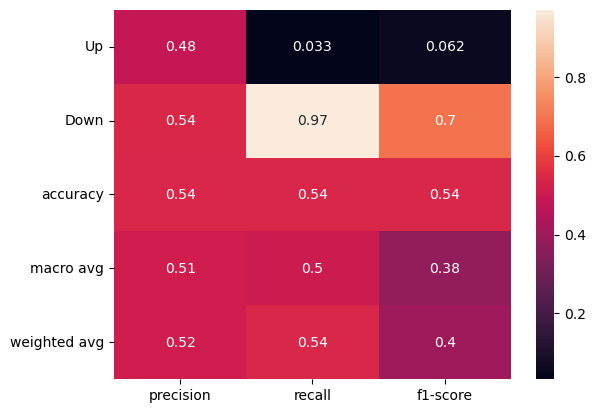

In [119]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)